## Problem Statement
### The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:

- bigdatamart_Train.csv: Use this file for the model building purpose. 

- bigdatamart_Test.csv: Use this file for getting predictions from the trained model. 

Note: You can find the dataset in the link below.

Downlaod Files:
https://github.com/dsrscientist/bigdatamart_rep

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('bigdatamart_train.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## EDA

In [3]:
a=df.shape
a

(8523, 12)

- training set has 8523 observations and 12 features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- there seems some null observations in the data

In [5]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Observations:

- there seems null values in item_ weight as count is less than other 8523
- item_weight seems normally distributed as median and mean are almost equal(need to verify this later)
- there may be some outliers in item_visibility as its min value is zero and there is huge diffeerence in 75% and max values and data seems right tailed skewed
- there is very little skewness in item_mrp
- outlet year is a categorical feature,, we may need to convert it years_old(sales data year(2013)-establishment year)
- outlet sales is right skewed as mean is higher than median, also there may be outlers in the data as there is huge difference between 75% and max values

In [6]:
df['years_old']=2013-df['Outlet_Establishment_Year']  #creating new feature on the basis of outlet establishment year

In [7]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,years_old
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914,15.168133
std,4.643456,0.051598,62.275067,8.371760,1706.499616,8.371760
min,4.555000,0.000000,31.290000,1985.000000,33.290000,4.000000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400,9.000000
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000,14.000000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400,26.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,28.000000


- years_old data is almost normally distributed with little skewness

In [8]:
df.skew()

Item_Weight                  0.082426
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
Item_Outlet_Sales            1.177531
years_old                    0.396641
dtype: float64

- as discussed above there is some skewness in item visibility and item outlet sales but they are in acceptable range

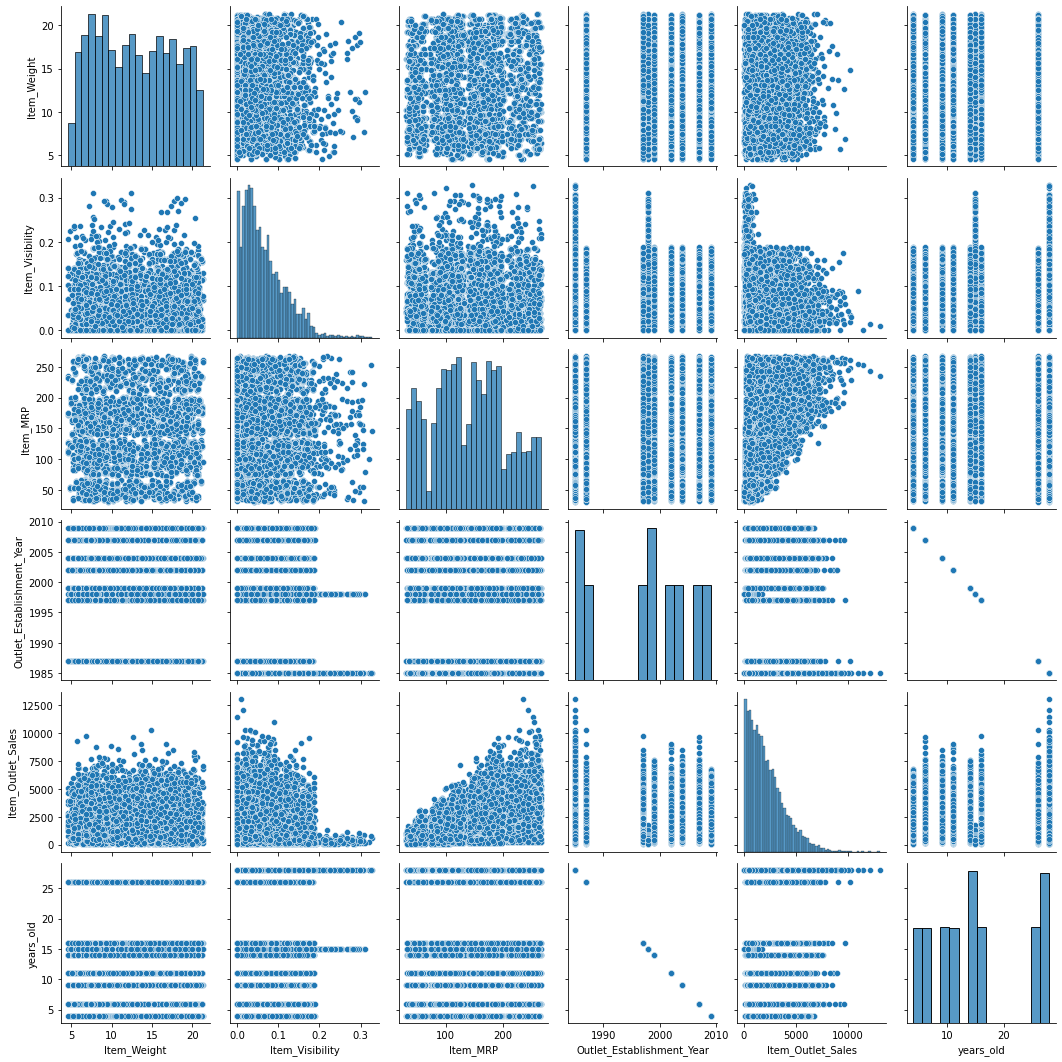

In [9]:
# Multivariate analysis
sns.pairplot(df)

- items with less mrp has low sales and items with higher mrp has sales with wide range
- items with visibility less than 0.2 has significantly higher sales than items with visibility greater than 0.2
- need to check for correlation as the plots dont show good corelation between the data

<AxesSubplot:>

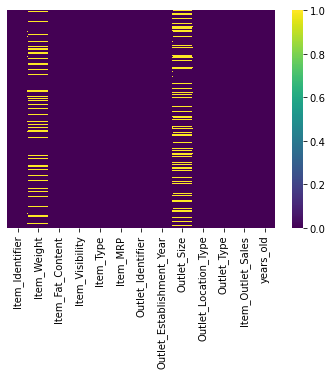

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cmap='viridis')

- there are null values in item weight and outlet size

In [11]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
years_old                       0
dtype: int64

- we need to impute these null values later

### Lets check for outliers

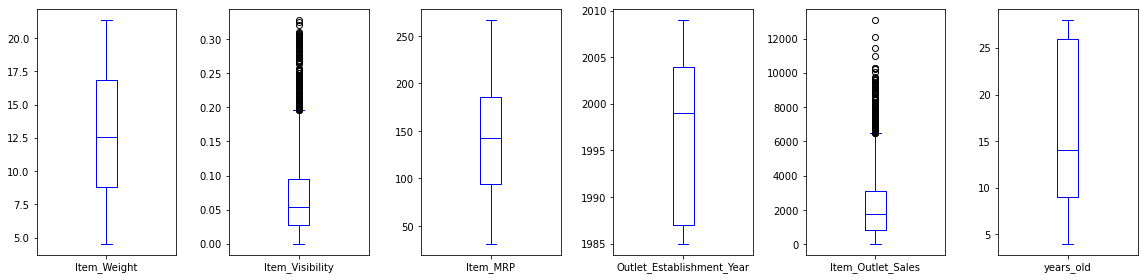

In [12]:
df.plot(kind='box',color='b',subplots=True,layout=(1,6),figsize=(16,4))
plt.tight_layout()

- as per the plots there are some possible outliers in item_Visibility and outlet saales as discussed above
- but as almost all the outlier points are close to the whiskers of item_visibility, so we will not remove them
- there are 4 possible outliers in outlet sales which far away from upper whisker so we will remove them

<AxesSubplot:xlabel='Outlet_Size', ylabel='count'>

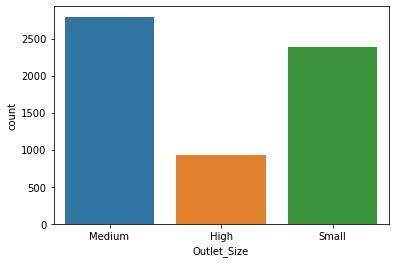

In [13]:
sns.countplot(df.Outlet_Size)

- count of outlet size is in this order 
#### Medium > Small > High

In [14]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'years_old'],
      dtype='object')

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='count'>

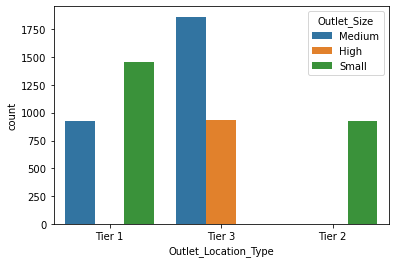

In [15]:
sns.countplot(df['Outlet_Location_Type'],hue=df.Outlet_Size)

- outlets at tier 2 location are of small size, so we can impute this for null outlet size with tier 2 location
- outlets at tier 1 location are mostly of small size and some are of Medium size
- outlets at tier 3 location are mostly of Medium size and some are of High size

<AxesSubplot:xlabel='Outlet_Type', ylabel='count'>

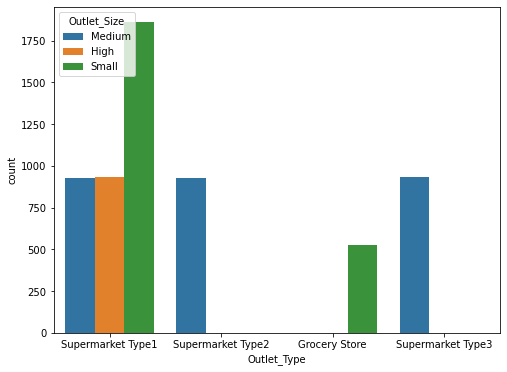

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(df['Outlet_Type'],hue=df.Outlet_Size)

- type1- mostly small outlets
- type2- all are medium outlets
- type3- all are medium outlets
- grocery- all are small outlets

#### Lets try to impute null values of outlet size

creating a function to impute null values of outlet size on the basis of outlet type

In [17]:
def size_imputer(cols):
    otype=cols[0]
    size=cols[1]
    
    if pd.isnull(size):
        
        if otype=='Supermarket Type3':
            return 'Medium'
        
        elif otype=='Supermarket Type2':
            return 'Medium'
        
        elif otype=='Grocery Store':
            return 'Small'
        
    else:
        return size

In [18]:
df['Outlet_Size']=df[['Outlet_Type','Outlet_Size']].apply(size_imputer,axis=1)

In [19]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1855
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
years_old                       0
dtype: int64

- some null values are reduced in outlet size

creating a function to impute null values of outlet size on the basis of outlet location type

In [20]:
def size_imputer1(cols):
    ltype=cols[0]
    size=cols[1]
    
    if pd.isnull(size):
        
        if ltype=='Tier 2':
            return 'Small'
        
    else:
        return size

In [21]:
df['Outlet_Size']=df[['Outlet_Location_Type','Outlet_Size']].apply(size_imputer1,axis=1)

In [22]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
years_old                       0
dtype: int64

- null values of Outlet size are imputed

### Imputing null values for Item_weight

<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Weight'>

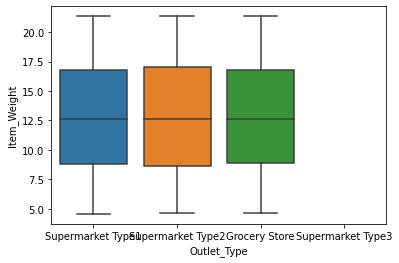

In [23]:
sns.boxplot(x='Outlet_Type',y='Item_Weight',data=df)

- boxplot is similar for all the outlet types

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='Item_Weight'>

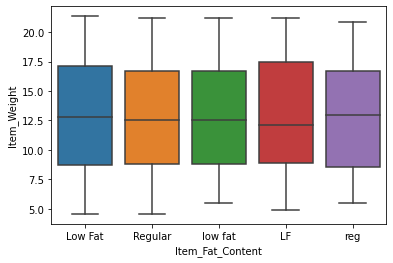

In [24]:
sns.boxplot(x='Item_Fat_Content',y='Item_Weight',data=df)

- in this also boxplot is similar for all the item_fat_Content

<AxesSubplot:xlabel='Item_Type', ylabel='Item_Weight'>

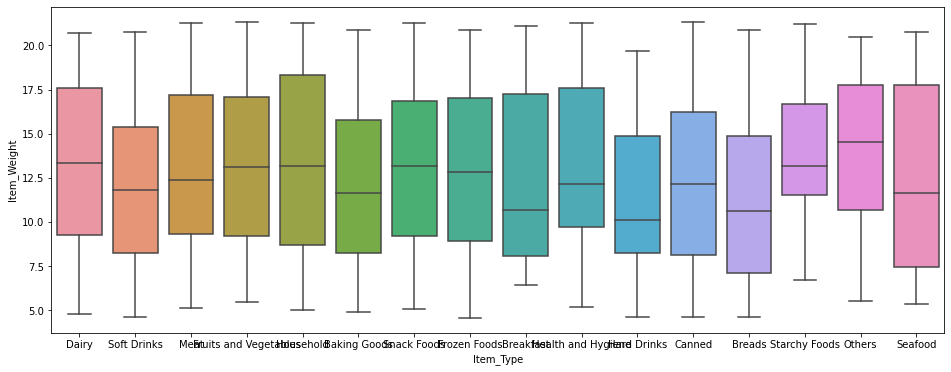

In [25]:
plt.figure(figsize=(16,6))
sns.boxplot(x='Item_Type',y='Item_Weight',data=df)

- mean weight is different for different item types
- but as there are too many item types, so imputing null weights with the mean of different item type weights may not help in improving our model
- so we will impute the null values with the mean value

In [26]:
df['Item_Weight']=df['Item_Weight'].replace(np.nan,df['Item_Weight'].mean())

In [27]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
years_old                    0
dtype: int64

- now there are no null values in our data

<AxesSubplot:>

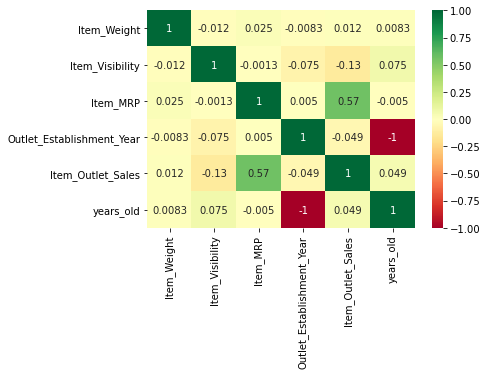

In [28]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn')

- there is some good correlation between item mrp and sales

In [29]:
df.Outlet_Identifier.value_counts()

OUT027    935
OUT013    932
OUT046    930
OUT049    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

<AxesSubplot:xlabel='Outlet_Identifier', ylabel='years_old'>

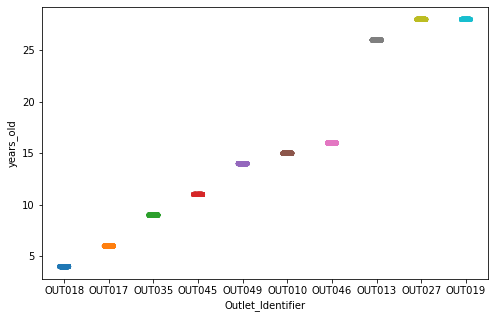

In [30]:
k=df.sort_values('years_old',ascending=True)
plt.figure(figsize=(8,5))
sns.stripplot(x='Outlet_Identifier',y='years_old',data=k)

#### as the plot shows, years old is directly related to outlet identifier, so we can drop this column

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

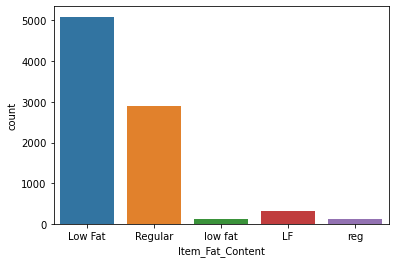

In [31]:
sns.countplot(df['Item_Fat_Content'])

- data is not clean in item fat content column
- there are only 2 categories but with different names.
- we need to replace the different names of same category with only one name

In [32]:
df['Item_Fat_Content']=df['Item_Fat_Content'].replace(['low fat','LF'],'Low Fat')
df['Item_Fat_Content']=df['Item_Fat_Content'].replace('reg','Regular')

<AxesSubplot:xlabel='Item_Fat_Content', ylabel='count'>

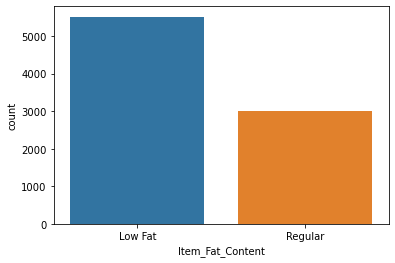

In [33]:
sns.countplot(df['Item_Fat_Content'])

- low fat items are almost double than the regular items

<AxesSubplot:xlabel='Item_Type', ylabel='Item_MRP'>

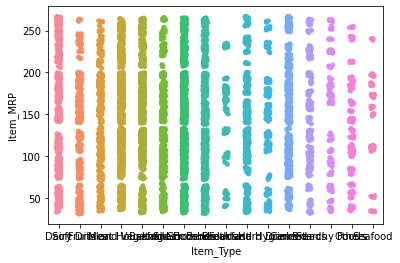

In [34]:
sns.stripplot(x='Item_Type',y='Item_MRP',data=df)

In [35]:
# almost all the item_type are priced from very low range to high range

### removing outliers from item outlet sales

In [36]:
df.nlargest(4,['Item_Outlet_Sales'])  # as per the boxplot, only top 4 values were far away from the whiskers

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,years_old
7188,NCE42,12.857645,Low Fat,0.010551,Household,234.9958,OUT027,1985,Medium,Tier 3,Supermarket Type3,13086.9648,28
5223,FDQ19,12.857645,Regular,0.014296,Fruits and Vegetables,242.6512,OUT027,1985,Medium,Tier 3,Supermarket Type3,12117.5600,28
1450,FDZ20,12.857645,Low Fat,0.000000,Fruits and Vegetables,253.0356,OUT027,1985,Medium,Tier 3,Supermarket Type3,11445.1020,28
4349,FDP33,12.857645,Low Fat,0.088840,Snack Foods,254.2672,OUT027,1985,Medium,Tier 3,Supermarket Type3,10993.6896,28


In [37]:
df.drop(df.nlargest(4,['Item_Outlet_Sales']).index,axis=0,inplace=True)

### Splitting data into attributes and labels and feature selection

In [38]:
# wwe will drop item identifier as its just signifies the item name
# we will drop outlet identifier as its just signifies the age of outlet which we will get from years_old
# we will drop outlet establishment year as we have transformed this data into years_old feature
# we will drop sales as it is our target/label column
x=df.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year','Item_Outlet_Sales'],axis=1)
y=df['Item_Outlet_Sales']

In [39]:
x.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,years_old
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,14
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,4
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,14
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,Small,Tier 3,Grocery Store,15
4,8.93,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,26


In [40]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

### Converting categorical data into numerical data

In [41]:
le=LabelEncoder()
x['Item_Fat_Content']=le.fit_transform(x['Item_Fat_Content'])
x['Outlet_Size']=le.fit_transform(x['Outlet_Size'])
# label encoding only in these data as they are not ordinal data

<AxesSubplot:xlabel='Item_Type', ylabel='count'>

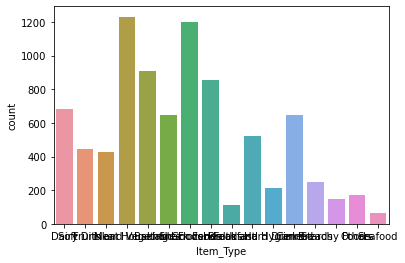

In [42]:
sns.countplot(x['Item_Type'])

In [43]:
# as there are too many categories, we will use label encoder for this as well
x['Item_Type']=le.fit_transform(x['Item_Type'])

In [44]:
x=pd.get_dummies(x,drop_first=True)

In [45]:
x.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,years_old,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,0.016047,4,249.8092,1,14,0,0,1,0,0
1,5.92,1,0.019278,14,48.2692,1,4,0,1,0,1,0
2,17.50,0,0.016760,10,141.6180,1,14,0,0,1,0,0
3,19.20,1,0.000000,6,182.0950,2,15,0,1,0,0,0
4,8.93,0,0.000000,9,53.8614,0,26,0,1,1,0,0


### Scaling the train data

In [46]:
sc=MinMaxScaler()
x=sc.fit_transform(x)
x=pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.282525,0.0,0.048866,0.266667,0.927507,0.5,0.416667,0.0,0.0,1.0,0.0,0.0
1,0.081274,1.0,0.058705,0.933333,0.072068,0.5,0.000000,0.0,1.0,0.0,1.0,0.0
2,0.770765,0.0,0.051037,0.666667,0.468288,0.5,0.416667,0.0,0.0,1.0,0.0,0.0
3,0.871986,1.0,0.000000,0.400000,0.640093,1.0,0.458333,0.0,1.0,0.0,0.0,0.0
4,0.260494,0.0,0.000000,0.600000,0.095805,0.0,0.916667,0.0,1.0,1.0,0.0,0.0


### Now we need to clean and transform our TEST data in same way

In [48]:
test=pd.read_csv('bigdatamart_test.csv')
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [50]:
test.shape

(5681, 11)

In [49]:
test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

- as null values are there we need to impute them

In [51]:
test['years_old']=2013-test['Outlet_Establishment_Year']  #creating new feature on the basis of outlet establishment year

In [52]:
# imputing null values
test['Outlet_Size']=test[['Outlet_Type','Outlet_Size']].apply(size_imputer,axis=1)

In [56]:
test['Outlet_Size']=test[['Outlet_Location_Type','Outlet_Size']].apply(size_imputer1,axis=1)

In [60]:
test['Item_Weight']=test['Item_Weight'].replace(np.nan,df['Item_Weight'].mean())

In [61]:
test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
years_old                    0
dtype: int64

In [62]:
## cleaning data of item fat content
test['Item_Fat_Content']=test['Item_Fat_Content'].replace(['low fat','LF'],'Low Fat')
test['Item_Fat_Content']=test['Item_Fat_Content'].replace('reg','Regular')

In [64]:
# we will not clean outliers as we want to see how well our model handles the outliers

In [66]:
# data splitting and feature selection
xt=test.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)

In [67]:
xt.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,years_old
0,20.750000,Low Fat,0.007565,Snack Foods,107.8622,Medium,Tier 1,Supermarket Type1,14
1,8.300000,Regular,0.038428,Dairy,87.3198,Small,Tier 2,Supermarket Type1,6
2,14.600000,Low Fat,0.099575,Others,241.7538,Small,Tier 3,Grocery Store,15
3,7.315000,Low Fat,0.015388,Snack Foods,155.0340,Small,Tier 2,Supermarket Type1,6
4,12.857645,Regular,0.118599,Dairy,234.2300,Medium,Tier 3,Supermarket Type3,28


In [68]:
# converting categorical feature into numerical feature
xt['Item_Fat_Content']=le.fit_transform(xt['Item_Fat_Content'])
xt['Outlet_Size']=le.fit_transform(xt['Outlet_Size'])

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,years_old
0,20.750000,0,0.007565,Snack Foods,107.8622,1,Tier 1,Supermarket Type1,14
1,8.300000,1,0.038428,Dairy,87.3198,2,Tier 2,Supermarket Type1,6
2,14.600000,0,0.099575,Others,241.7538,2,Tier 3,Grocery Store,15
3,7.315000,0,0.015388,Snack Foods,155.0340,2,Tier 2,Supermarket Type1,6
4,12.857645,1,0.118599,Dairy,234.2300,1,Tier 3,Supermarket Type3,28
...,...,...,...,...,...,...,...,...,...
5676,10.500000,1,0.013496,Snack Foods,141.3154,2,Tier 1,Supermarket Type1,16
5677,7.600000,1,0.142991,Starchy Foods,169.1448,1,Tier 3,Supermarket Type2,4
5678,10.000000,0,0.073529,Health and Hygiene,118.7440,2,Tier 2,Supermarket Type1,11
5679,15.300000,1,0.000000,Canned,214.6218,2,Tier 2,Supermarket Type1,6


In [70]:
xt['Item_Type']=le.fit_transform(xt['Item_Type'])

In [71]:
xt=pd.get_dummies(xt,drop_first=True)

In [73]:
xt=sc.fit_transform(xt)
xt=pd.DataFrame(xt)
xt.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.964275,0.0,0.023374,0.866667,0.323413,0.5,0.416667,0.0,0.0,1.0,0.0,0.0
1,0.222983,1.0,0.118737,0.266667,0.235849,1.0,0.083333,1.0,0.0,1.0,0.0,0.0
2,0.598095,0.0,0.307674,0.733333,0.894140,1.0,0.458333,0.0,1.0,0.0,0.0,0.0
3,0.164335,0.0,0.047548,0.866667,0.524488,1.0,0.083333,1.0,0.0,1.0,0.0,0.0
4,0.494352,1.0,0.366458,0.266667,0.862069,0.5,1.000000,0.0,1.0,0.0,0.0,1.0


### Now train and test data are prepared

### train test split

In [76]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=42)

## Modeling

In [117]:
## making a function to evaluate metrics for different algorithms and check for cross validaton
def model_test(model):
    ml=model()
    ml.fit(x_train,y_train)
    y_pred=ml.predict(x_test)
    print('mse of ',type(ml).__name__,' : ', mean_squared_error(y_test,y_pred))
    print('rmse of ',type(ml).__name__,' : ', mean_squared_error(y_test,y_pred,squared=False))
    print('r2 score for test data for ',type(ml).__name__,' : ', r2_score(y_test,y_pred))
    y_predt=ml.predict(x_train)
    print('r2 score for train data for ',type(ml).__name__,' : ', r2_score(y_train,y_predt))
    ## cross validation
    kf=KFold(n_splits=10)
    r2=[]
    for train_index,test_index in kf.split(x,y):
        xtrain,xtest=x.iloc[train_index],x.iloc[test_index]
        ytrain,ytest=y.iloc[train_index],y.iloc[test_index]
        ml.fit(xtrain,ytrain)
        ypred=ml.predict(xtest)
        r2.append(r2_score(ytest,ypred))
    print('r2 scores of ',type(ml).__name__,' :\n\n', r2)
    print('\nmean of r2 scores of ',type(ml).__name__,' : ', sum(r2)/len(r2))

In [118]:
model_test(LinearRegression)

mse of  LinearRegression  :  1287681.4451158766
rmse of  LinearRegression  :  1134.760523245269
r2 score for test data for  LinearRegression  :  0.5493336357300698
r2 score for train data for  LinearRegression  :  0.5685847247644591
r2 scores of  LinearRegression  :

 [0.5602687365865029, 0.5845545334860016, 0.5431241890077606, 0.565074708174129, 0.5114690769362807, 0.5751402559835839, 0.5798093945333104, 0.5537672273857028, 0.5863973336953998, 0.5478796561623864]

mean of r2 scores of  LinearRegression  :  0.5607485111951058


-  linear model performed average
- overfitting is not visible by checking train data score
- lets check for other models

In [119]:
model_test(DecisionTreeRegressor)

mse of  DecisionTreeRegressor  :  2412782.6499962904
rmse of  DecisionTreeRegressor  :  1553.3134422891892
r2 score for test data for  DecisionTreeRegressor  :  0.155567559995752
r2 score for train data for  DecisionTreeRegressor  :  1.0
r2 scores of  DecisionTreeRegressor  :

 [0.2415672868649983, 0.22526664210063774, 0.11803783488141106, 0.25459286258503167, 0.17063712334120373, 0.22372786110617238, 0.15915134021138444, 0.15155221886359815, 0.28226090652728797, 0.13364213993337493]

mean of r2 scores of  DecisionTreeRegressor  :  0.19604362164151004


- Decision tree performed very poorly as it is overfitting the data to its complete depth

In [120]:
model_test(KNeighborsRegressor)

mse of  KNeighborsRegressor  :  1398486.2834328646
rmse of  KNeighborsRegressor  :  1182.5761216229864
r2 score for test data for  KNeighborsRegressor  :  0.510553847594394
r2 score for train data for  KNeighborsRegressor  :  0.6822358174799077
r2 scores of  KNeighborsRegressor  :

 [0.5001377703582495, 0.5215583365102214, 0.46526901907424634, 0.5125698829288952, 0.4369425081615719, 0.520398197430463, 0.5563381481017969, 0.534150317893288, 0.5919884108458557, 0.5162240909269191]

mean of r2 scores of  KNeighborsRegressor  :  0.5155576682231506


- KNeighbors performed moderately but not better than linear regression as it also shows some extent of overfitting

In [121]:
model_test(RandomForestRegressor)

mse of  RandomForestRegressor  :  1334802.2089958976
rmse of  RandomForestRegressor  :  1155.3364051201268
r2 score for test data for  RandomForestRegressor  :  0.5328421786076756
r2 score for train data for  RandomForestRegressor  :  0.9369022616067095
r2 scores of  RandomForestRegressor  :

 [0.5513628230814722, 0.5825339528650991, 0.500055404354478, 0.5666204249129381, 0.4826821805406243, 0.5611644043669972, 0.5623727582288176, 0.5531818708868076, 0.5924183378125513, 0.5265451794557577]

mean of r2 scores of  RandomForestRegressor  :  0.5478937336505543


- Random forest performed almost closed to linear regression but it is also overfitting the just like decision tree

In [122]:
model_test(AdaBoostRegressor)

mse of  AdaBoostRegressor  :  1527903.604648849
rmse of  AdaBoostRegressor  :  1236.0839796101432
r2 score for test data for  AdaBoostRegressor  :  0.46526001048337395
r2 score for train data for  AdaBoostRegressor  :  0.493876568947488
r2 scores of  AdaBoostRegressor  :

 [0.4821094852440264, 0.49862932701136053, 0.43061999937054685, 0.44588857678288996, 0.30570704189329223, 0.5017570865737169, 0.4662119735072826, 0.4692475742571214, 0.508376388816601, 0.40183337986136014]

mean of r2 scores of  AdaBoostRegressor  :  0.4510380833318199


- adaboost didnt perform very well but is not overfitting the data

In [123]:
model_test(XGBRegressor)

mse of  XGBRegressor  :  1369647.7166227703
rmse of  XGBRegressor  :  1170.3194933960428
r2 score for test data for  XGBRegressor  :  0.5206468501023949
r2 score for train data for  XGBRegressor  :  0.8748575445635067
r2 scores of  XGBRegressor  :

 [0.538008036529157, 0.5459398512102451, 0.4813056638580492, 0.5484107092002113, 0.45750233719682387, 0.5351071757905397, 0.5697446840526021, 0.5308642631253779, 0.5726434566792564, 0.513226806655336]

mean of r2 scores of  XGBRegressor  :  0.5292752984297598


- xg boost didnt work better than linear models
- it is overfitting the data
- from all the models, only linear model worked well, lets try its other modifications

In [125]:
model_test(Lasso)

mse of  Lasso  :  1287695.7528057166
rmse of  Lasso  :  1134.7668275049798
r2 score for test data for  Lasso  :  0.5493286282846447
r2 score for train data for  Lasso  :  0.5685052524225291
r2 scores of  Lasso  :

 [0.5599968113888394, 0.5842145866278338, 0.5429772321165032, 0.5652978703441985, 0.5126165056201992, 0.5755621892533411, 0.5801700827287078, 0.5537022577610832, 0.5868083473624675, 0.5475093329602476]

mean of r2 scores of  Lasso  :  0.5608855216163421


- performed same as Linear regression
- no overfitting problem which is quite expected as there is no overfitting problem in the linear regression as well

In [126]:
model_test(Ridge)

mse of  Ridge  :  1287073.8772268654
rmse of  Ridge  :  1134.492784122872
r2 score for test data for  Ridge  :  0.5495462740441701
r2 score for train data for  Ridge  :  0.5685737910032567
r2 scores of  Ridge  :

 [0.5601783523861081, 0.5845690733793361, 0.5430830998213352, 0.5651283519616708, 0.5116799430049752, 0.5751790478513528, 0.5797881019095243, 0.5536185503301454, 0.5863700174495894, 0.5479347871336301]

mean of r2 scores of  Ridge  :  0.5607529325227667


### Lets try Hyperparameter tuning to improve the model accuracy

- we will tune only lasso, ridge and random forest as only these models are giving better results than others

### Lasso

In [135]:
para={'alpha':[0,0.1,0.2,0.5,0.7,0.9,1],
      'random_state':[42,]}

ls_reg=GridSearchCV(estimator=Lasso(),
                    param_grid=para,
                    scoring='neg_mean_squared_error',
                    cv=10,
                    n_jobs=-1)

ls_reg.fit(x_train,y_train)
print('best score ',-ls_reg.best_score_)
print('best parameters \n',ls_reg.best_params_)

best score  1243366.178955994
best parameters 
 {'alpha': 1, 'random_state': 42}


- giving the default parameters

In [136]:
# for checking hypertuned model
def model_test1(ml):
    ml.fit(x_train,y_train)
    y_pred=ml.predict(x_test)
    print('mse of ',type(ml).__name__,' : ', mean_squared_error(y_test,y_pred))
    print('rmse of ',type(ml).__name__,' : ', mean_squared_error(y_test,y_pred,squared=False))
    print('r2 score for test data for ',type(ml).__name__,' : ', r2_score(y_test,y_pred))
    y_predt=ml.predict(x_train)
    print('r2 score for train data for ',type(ml).__name__,' : ', r2_score(y_train,y_predt))
    ## cross validation
    kf=KFold(n_splits=10)
    r2=[]
    for train_index,test_index in kf.split(x,y):
        xtrain,xtest=x.iloc[train_index],x.iloc[test_index]
        ytrain,ytest=y.iloc[train_index],y.iloc[test_index]
        ml.fit(xtrain,ytrain)
        ypred=ml.predict(xtest)
        r2.append(r2_score(ytest,ypred))
    print('r2 scores of ',type(ml).__name__,' :\n\n', r2)
    print('\nmean of r2 scores of ',type(ml).__name__,' : ', sum(r2)/len(r2))

In [137]:
ls=Lasso(random_state=42)
model_test1(ls)

mse of  Lasso  :  1287695.7528057166
rmse of  Lasso  :  1134.7668275049798
r2 score for test data for  Lasso  :  0.5493286282846447
r2 score for train data for  Lasso  :  0.5685052524225291
r2 scores of  Lasso  :

 [0.5599968113888394, 0.5842145866278338, 0.5429772321165032, 0.5652978703441985, 0.5126165056201992, 0.5755621892533411, 0.5801700827287078, 0.5537022577610832, 0.5868083473624675, 0.5475093329602476]

mean of r2 scores of  Lasso  :  0.5608855216163421


- No improvement

### Ridge

In [139]:
# lets check for ridge
para={'alpha':[0,0.1,0.2,0.3,0.4,0.5,0.7,0.9,1],
      'random_state':[42,]}

rg_reg=GridSearchCV(estimator=Ridge(),
                    param_grid=para,
                    scoring='neg_mean_squared_error',
                    cv=10,
                    n_jobs=-1)

rg_reg.fit(x_train,y_train)
print('best score ',-rg_reg.best_score_)
print('best parameters \n',rg_reg.best_params_)

best score  1243812.7441885318
best parameters 
 {'alpha': 0.3, 'random_state': 42}


In [140]:
rg=Ridge(alpha=0.3,random_state=42)
model_test1(rg)

mse of  Ridge  :  1287489.2714489384
rmse of  Ridge  :  1134.6758442167254
r2 score for test data for  Ridge  :  0.5494008932090961
r2 score for train data for  Ridge  :  0.5685837176951782
r2 scores of  Ridge  :

 [0.5602428773761237, 0.5845607188518578, 0.5431130975916574, 0.5650921828468569, 0.5115333664819189, 0.5751530459474892, 0.5798039076666643, 0.5537233751070412, 0.5863900257761514, 0.5478979651475498]

mean of r2 scores of  Ridge  :  0.5607510562793311


- no improvement

### Random forest

In [151]:
para={
    'n_estimators':[200,300,400],
    'criterion':['mse','mae'],
    'max_depth':[3,4,5,6],
    'random_state':[42,],
    'max_samples':[800,1000,1200]
}

rf_reg=GridSearchCV(estimator=RandomForestRegressor(),
                   param_grid=para,
                   scoring='neg_mean_squared_error',
                   cv=10,
                   n_jobs=-1)

rf_reg.fit(x_train,y_train)
print('best score ',-rf_reg.best_score_)
print('best parameters \n',rf_reg.best_params_)

best score  1142598.7836754401
best parameters 
 {'criterion': 'mse', 'max_depth': 5, 'max_samples': 1000, 'n_estimators': 300, 'random_state': 42}


In [152]:
rf1=RandomForestRegressor(max_depth=5,max_samples=1000,n_estimators=300,random_state=42)
model_test1(rf1)

mse of  RandomForestRegressor  :  1170642.889855213
rmse of  RandomForestRegressor  :  1081.9625177681587
r2 score for test data for  RandomForestRegressor  :  0.5902951176080524
r2 score for train data for  RandomForestRegressor  :  0.6197935845968994
r2 scores of  RandomForestRegressor  :

 [0.6053945128489617, 0.6208150016335922, 0.5734658885285707, 0.6059809360316326, 0.5339047653877655, 0.6116390569958634, 0.6271872095211641, 0.5940880988128308, 0.6368190992871601, 0.5782181675834714]

mean of r2 scores of  RandomForestRegressor  :  0.5987512736631012


- so performance of random forest improved after hypertuning
- r2 score also improved(better than lasso/ridge)
- r2 score=~60%

### Training the model for complete data set

In [158]:
rf1.fit(x,y)

RandomForestRegressor(max_depth=5, max_samples=1000, n_estimators=300,
                      random_state=42)

### Predicting sales amount for test data

In [159]:
yt_pred=rf1.predict(xt)
yt_pred=pd.DataFrame(yt_pred)
yt_pred

,0
0,1704.253590
1,1394.818962
2,766.997083
3,2553.962615
4,5786.241270
...,...
5676,2208.796995
5677,2568.703785
5678,1934.722988
5679,3706.260425


- since we have only xlabel in our test data, we cannot verify result from our test data

### Saving the model

In [161]:
joblib.dump(rf1,'bigdatamart.pkl')

['bigdatamart.pkl']

In [162]:
model=joblib.load('bigdatamart.pkl')
y_predd=model.predict(x_test)
print('mse',mean_squared_error(y_test,y_predd))
print('rmse',mean_squared_error(y_test,y_predd,squared=False))
print('r2 score',r2_score(y_test,y_predd))

mse 1129267.0049470116
rmse 1062.6697534733034
r2 score 0.6047759658727816
